<a href="https://colab.research.google.com/github/tpminhtam/Design-a-Robot-Vacuum/blob/main/Project_Design_a_Robot_Vacuum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

                  Simple Reflex Agent  Model-Based Reflex Agent
Environment Size                                               
100x100                         61.37                     12.59
10x10                           19.79                      6.52
5x5                              5.17                      3.08


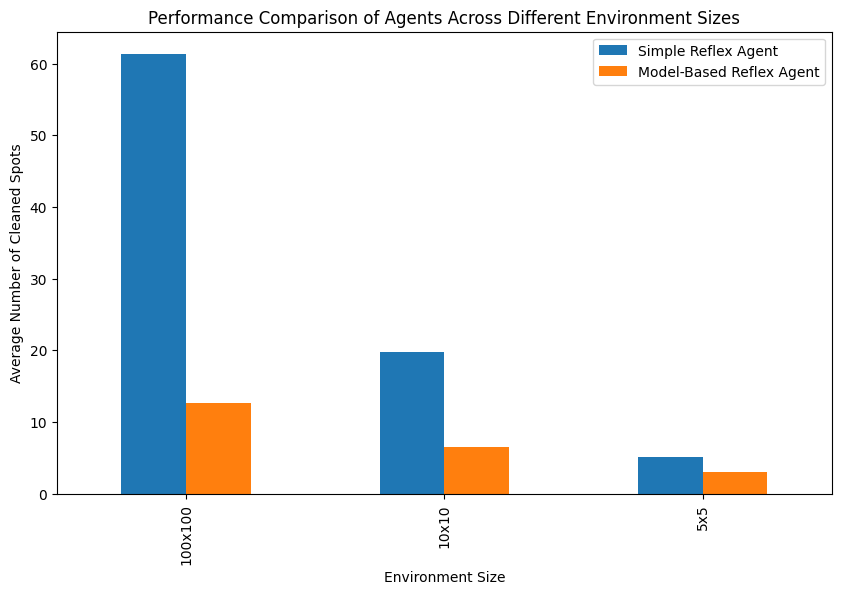

In [3]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

actions = ["north", "east", "west", "south", "suck"]

def simple_randomized_agent(bumpers, dirty):
    return np.random.choice(actions)

def simple_reflex_agent(bumpers, dirty):
    if dirty:
        return "suck"

    # Filter out actions with a bump
    possible_actions = [action for action in actions if (action != 'suck' and not bumpers[action])]

    # Randomly choose an action
    return np.random.choice(possible_actions)

def model_based_reflex_agent(bumpers, dirty, state):
    # Update state to remember visited locations
    state["visited"].add(tuple(state["location"]))

    if dirty:
        # State is added to the simulation_environment below
        state["room"][state["location"][0]][state["location"][1]] = 0
        return "suck"

    moves = []
    if not bumpers["north"]:
        moves.append("north")
    if not bumpers["south"]:
        moves.append("south")
    if not bumpers["west"]:
        moves.append("west")
    if not bumpers["east"]:
        moves.append("east")

    # Choose an action based on state
    action = np.random.choice(moves)
    return action

# Adding size to the above simulation_environment to run different size of rooms
def simulation_environment(agent, max_steps, size, model_based = True, verbose = True):

    # create a 5 x 5 matrix with random 0 (clean) and 1 (dirty) which occurs at p = 0.2
    room = [[1 if random.random() < 0.2 else 0 for _ in range(size)] for _ in range(size)]

    count_dirty = sum(sum(row) for row in room)

    num_cleaned = 0
    step = 0
    dirty = False

    # keep track of agent's location
    location = [random.randint(0, size - 1), random.randint(0, size - 1)]

    # UPDATED to add state
    state = {
        "room": [row[:] for row in room],
        "location": location,
        "visited": set()
    }

    while max_steps > 0 and count_dirty > num_cleaned:
        dirty = room[location[0]][location[1]] == 1

        # define bumpers. True means it is at the bumper, robot cannot move that direction
        # limit for the south and east are size - 1
        bumpers = {
            "north" : location[0] == 0,
            "south" : location[0] == size - 1,
            "west" : location[1] == 0,
            "east" : location[1] == size - 1
        }
        # UPDATED to switch between model_based or simple reflex
        if model_based:
            action = agent(bumpers, dirty, state)
        else:
            action = agent(bumpers, dirty)

        if (verbose): print("step", step , "- action:", action)

        if (action == "suck"):
            if dirty:
                num_cleaned += 1
                room[location[0]][location[1]] = 0

        elif (action == "north") and not bumpers["north"] and not (location[0] - 1, location[1]) in state['visited']:
            location[0] -= 1
        elif (action == "south") and not bumpers["south"] and not (location[0] + 1, location[1]) in state['visited']:
            location[0] += 1
        elif (action == "west") and not bumpers["west"] and not (location[0], location[1] - 1) in state['visited']:
            location[1] -= 1
        elif (action == "east") and not bumpers["east"] and not (location[0], location[1] + 1) in state['visited']:
            location[1] += 1

        if model_based:
            state["location"] = location

        step += 1
        max_steps -= 1

    return num_cleaned

sizes = [5, 10, 100]
num_simulations = 100
max_steps = 1000

# Collect results
results = []

for size in sizes:
    for _ in range(num_simulations):
        cleaned_simple = simulation_environment(simple_reflex_agent, max_steps, size, model_based=False, verbose=False)
        cleaned_model_based = simulation_environment(model_based_reflex_agent, max_steps, size, model_based=True, verbose=False)

        results.append({
            "Environment Size": f"{size}x{size}",
            "Simple Reflex Agent": cleaned_simple,
            "Model-Based Reflex Agent": cleaned_model_based
        })

df = pd.DataFrame(results)

# Calculate the average performance
avg_performance = df.groupby("Environment Size").mean()

# Display the results as a table
print(avg_performance)

# Plotting results
avg_performance.plot(kind="bar", figsize=(10, 6))
plt.title("Performance Comparison of Agents Across Different Environment Sizes")
plt.ylabel("Average Number of Cleaned Spots")
plt.show()